In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , OneHotEncoder ,PolynomialFeatures
from category_encoders import BinaryEncoder
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from imblearn.pipeline import make_pipeline ,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate,GridSearchCV,KFold,RandomizedSearchCV,train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import joblib
from prophet import Prophet
from sklearn.feature_selection import SelectFromModel

In [17]:
df = pd.read_csv("car_prices_cleaned.csv")
df

,Unnamed: 0,year,make,model,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,saledate,distance_category,season,sale_category,country_name
0,0,2015,Kia,Sorento,Suv,Automatic,Ca,5.0,16639.0,White,Black,20500.0,21500.0,2014-12-16 12:30:00,<= 25000,Winter,Less_than_expected,Canada
1,1,2015,Kia,Sorento,Suv,Automatic,Ca,5.0,9393.0,White,Beige,20800.0,21500.0,2014-12-16 12:30:00,<= 25000,Winter,Less_than_expected,Canada
2,2,2014,Bmw,3 series,Sedan,Automatic,Ca,45.0,1331.0,Gray,Black,31900.0,30000.0,2015-01-15 04:30:00,<= 25000,Winter,Higher_than_expected,Canada
3,3,2015,Volvo,S60,Sedan,Automatic,Ca,41.0,14282.0,White,Black,27500.0,27750.0,2015-01-29 04:30:00,<= 25000,Winter,Less_than_expected,Canada
4,4,2014,Bmw,6 series gran coupe,Sedan,Automatic,Ca,43.0,2641.0,Gray,Black,66000.0,67000.0,2014-12-18 12:30:00,<= 25000,Winter,Less_than_expected,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499437,558832,2015,Kia,K900,Sedan,Automatic,In,45.0,18255.0,Silver,Black,35300.0,33000.0,2015-07-09 07:00:00,<= 25000,Summer,Higher_than_expected,India
499438,558833,2012,Ram,2500,Crew cab,Automatic,Wa,5.0,54393.0,White,Black,30200.0,30800.0,2015-07-08 09:30:00,50001-75000,Summer,Less_than_expected,Wa
499439,558834,2012,Bmw,X5,Suv,Automatic,Ca,48.0,50561.0,Black,Black,29800.0,34000.0,2015-07-08 09:30:00,50001-75000,Summer,Less_than_expected,Canada
499440,558835,2015,Nissan,Altima,Sedan,Automatic,Ga,38.0,16658.0,White,Black,15100.0,11100.0,2015-07-09 06:45:00,<= 25000,Summer,Higher_than_expected,Gabon


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499442 entries, 0 to 499441
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         499442 non-null  int64  
 1   year               499442 non-null  int64  
 2   make               499442 non-null  object 
 3   model              499442 non-null  object 
 4   body               499442 non-null  object 
 5   transmission       499442 non-null  object 
 6   state              499442 non-null  object 
 7   condition          499442 non-null  float64
 8   odometer           499442 non-null  float64
 9   color              499442 non-null  object 
 10  interior           499442 non-null  object 
 11  mmr                499442 non-null  float64
 12  sellingprice       499442 non-null  float64
 13  saledate           499442 non-null  object 
 14  distance_category  499442 non-null  object 
 15  season             499442 non-null  object 
 16  sa

# Class Imbalance [transmission]

In [19]:
df["transmission"].value_counts(normalize=True)

transmission
Automatic    0.96911
Manual       0.03089
Name: proportion, dtype: float64

# corr

<Axes: >

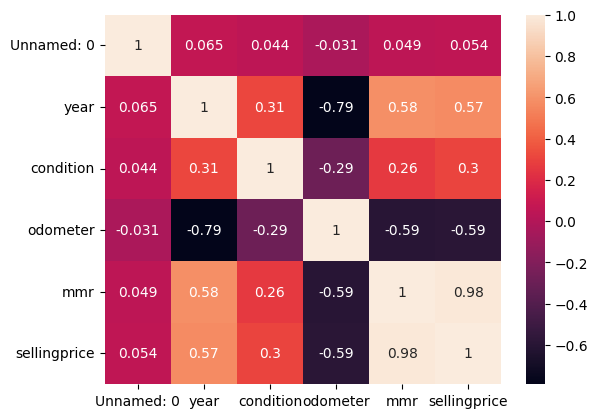

In [20]:
sns.heatmap(df.select_dtypes('number').corr() , annot=True )

# Manual Feature Selection

In [21]:
df['full_model'] = df['make'] + ' ' + df['model']

In [22]:
df.drop(["Unnamed: 0","make","model","transmission","saledate","distance_category","sale_category","mmr","country_name"],axis=1 , inplace=True)

In [23]:
df

,year,body,state,condition,odometer,color,interior,sellingprice,season,full_model
0,2015,Suv,Ca,5.0,16639.0,White,Black,21500.0,Winter,Kia Sorento
1,2015,Suv,Ca,5.0,9393.0,White,Beige,21500.0,Winter,Kia Sorento
2,2014,Sedan,Ca,45.0,1331.0,Gray,Black,30000.0,Winter,Bmw 3 series
3,2015,Sedan,Ca,41.0,14282.0,White,Black,27750.0,Winter,Volvo S60
4,2014,Sedan,Ca,43.0,2641.0,Gray,Black,67000.0,Winter,Bmw 6 series gran coupe
...,...,...,...,...,...,...,...,...,...,...
499437,2015,Sedan,In,45.0,18255.0,Silver,Black,33000.0,Summer,Kia K900
499438,2012,Crew cab,Wa,5.0,54393.0,White,Black,30800.0,Summer,Ram 2500
499439,2012,Suv,Ca,48.0,50561.0,Black,Black,34000.0,Summer,Bmw X5
499440,2015,Sedan,Ga,38.0,16658.0,White,Black,11100.0,Summer,Nissan Altima


In [24]:
df.describe()

,year,condition,odometer,sellingprice
count,499442.000000,499442.000000,499442.000000,499442.000000
mean,2010.283903,30.833819,63929.827954,13888.466228
std,3.723690,13.296988,45859.932008,9584.447729
min,1990.000000,1.000000,1.000000,1.000000
25%,2008.000000,24.000000,27963.000000,7500.000000
50%,2012.000000,35.000000,50300.000000,12400.000000
75%,2013.000000,42.000000,94422.000000,18400.000000
max,2015.000000,49.000000,201062.000000,230000.000000


# outliers

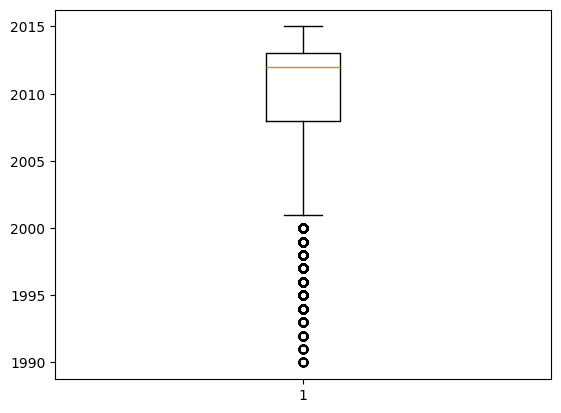

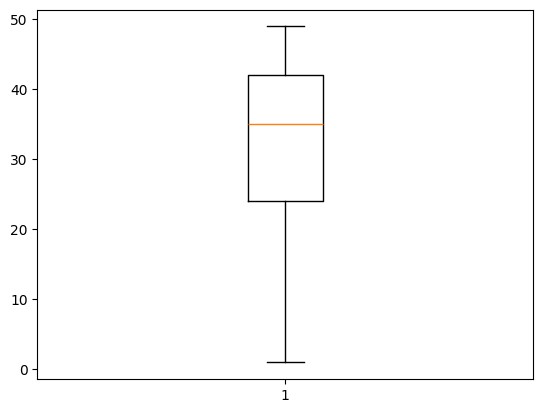

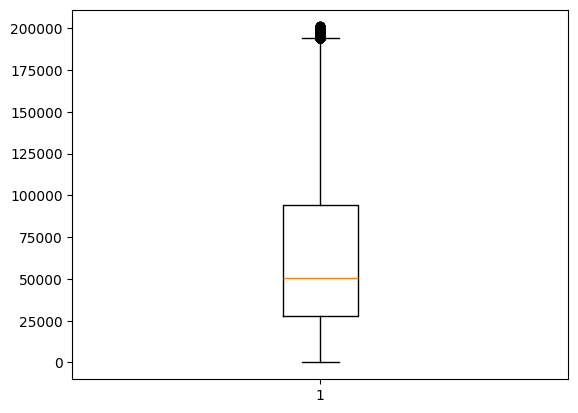

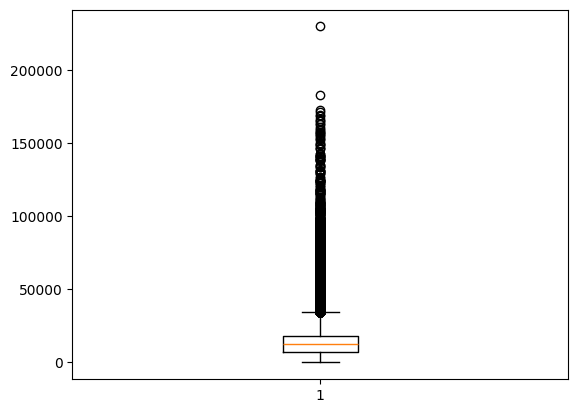

In [71]:
for col in df.select_dtypes("number").columns :
    plt.figure()
    plt.boxplot(df[col])

<Axes: xlabel='year', ylabel='sellingprice'>

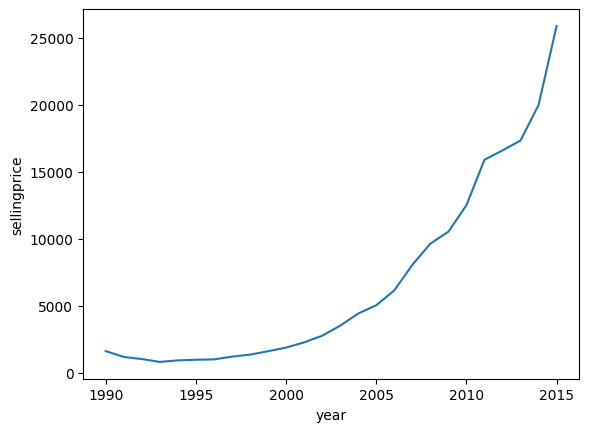

In [57]:
sns.lineplot(data=df.groupby("year")["sellingprice"].mean())

## Separate X and y, and log-transform the target to handle skewed distribution

In [25]:
x,y =df.drop(["sellingprice"],axis=1),df["sellingprice"]
log_y = np.log(y)

In [26]:
log_y

0          9.975808
1          9.975808
2         10.308953
3         10.230991
4         11.112448
            ...    
499437    10.404263
499438    10.335270
499439    10.434116
499440     9.314700
499441    10.192419
Name: sellingprice, Length: 499442, dtype: float64

## Print the number of unique values in each categorical (object-type) column

In [89]:
for col in df.select_dtypes("O").columns :
    print(f"{col} --{df[col].nunique() }")

body --44
state --38
color --19
interior --17
season --3
full_model --771


# encoder

In [27]:
encoder = ColumnTransformer(
    transformers=[("be",BinaryEncoder(),["full_model","state","body","color","interior"]),
                  ("ohe",OneHotEncoder(sparse_output=False,drop="first"),["season"])
    
],remainder="passthrough")
encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('be', BinaryEncoder(),
                                 ['full_model', 'state', 'body', 'color',
                                  'interior']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['season'])])

## Evaluate multiple models using cross-validation and print average R² scores

In [90]:
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    DecisionTreeRegressor(),
#RandomForestRegressor()
]

In [79]:
for model in models:
    pl = make_pipeline(encoder,StandardScaler(),model)
    cv = cross_validate(estimator=pl , X=x ,y=log_y ,cv=KFold(n_splits=5),scoring="r2",return_train_score=True)
    print(model)
    print(f"avg train scoring : {cv["train_score"].mean()}")
    print(f"avg test scoring : {cv["test_score"].mean()}")
    print('-'*50)

LinearRegression()
avg train scoring : 0.7076940750970533
avg test scoring : 0.7042704071457999
--------------------------------------------------
Lasso()
avg train scoring : 0.0
avg test scoring : -0.0050711787511084514
--------------------------------------------------
Ridge()
avg train scoring : 0.7076940750944292
avg test scoring : 0.7042704239582049
--------------------------------------------------
DecisionTreeRegressor()
avg train scoring : 0.9999998070708432
avg test scoring : 0.8132651106546216
--------------------------------------------------


In [80]:
lr = make_pipeline(encoder,StandardScaler(),PolynomialFeatures(),LinearRegression())

In [81]:
lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [82]:
lr_params = [
    {
        'polynomialfeatures__degree' : [2,3,4,5 ,1],
    }
]

In [86]:
lr_srch =GridSearchCV(estimator=lr,param_grid=lr_params,scoring="r2",cv=KFold(n_splits=5),return_train_score=True)

In [87]:
lr_srch

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('be',
                                                                         BinaryEncoder(),
                                                                         ['full_model',
                                                                          'state',
                                                                          'body',
                                                                          'color']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid=[{'polynomialfeatures__degree': [2, 3, 4, 5, 1]}],
             return_train_score=True, scoring='r2')

In [88]:
lr_srch.fit(x, log_y)

C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\imblearn\pipeline.py", line 329, in f

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('be',
                                                                         BinaryEncoder(),
                                                                         ['full_model',
                                                                          'state',
                                                                          'body',
                                                                          'color']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid=[{'polynomialfeatures__degree': [2, 3, 4, 5, 1]}],
             return_train_score=True, scoring='r2')

In [89]:
lr_srch.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

In [90]:
lr_srch.best_score_

np.float64(0.7042704071457994)

In [91]:
lr_srch.best_params_

{'polynomialfeatures__degree': 1}

In [99]:
DT = make_pipeline(encoder,StandardScaler(),DecisionTreeRegressor())

In [100]:
DT

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [114]:
param_dist = {
    "decisiontreeregressor__max_depth": [5, 10, 15, 20, None],
    "decisiontreeregressor__min_samples_split": [2, 5, 10, 20],
    "decisiontreeregressor__min_samples_leaf": [1, 2, 4, 8],
    "decisiontreeregressor__max_features": [None, "auto", "sqrt", "log2"],
    "decisiontreeregressor__max_leaf_nodes": [None, 10, 20, 30, 50],
}

In [119]:
DT_srch =RandomizedSearchCV(estimator=DT,param_distributions=param_dist , scoring="r2",cv=KFold(n_splits=5),return_train_score=True,n_jobs=-1)

In [120]:
DT_srch

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('be',
                                                                               BinaryEncoder(),
                                                                               ['full_model',
                                                                                'state',
                                                                                'body',
                                                                                'color']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               ['season'])])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('decisi...
                   n_jobs=-1,
                   param_distributions={'decisiontreeregressor__max_depth': [5,
                                                                             10,
                                                                             15,
                                                                             20,
                                                                             None],
                                        'decisiontreeregressor__max_features': [None,
                                                                                'auto',
                                                                                'sqrt',
                                                                                'log2'],
                                        'decisiontreeregressor__max_leaf_nodes': [None,
                                                                                  10,
                                                                                  20,
                                                                                  30,
                                                                                  50],
                                        'decisiontreeregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4,
                                                                                    8],
                                        'decisiontreeregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10,
                                                                                     20]},
                   return_train_score=True, scoring='r2')

In [121]:
DT_srch.fit(x,log_y)

C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\imblearn\pipeline.py", line 333, in f

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('be',
                                                                               BinaryEncoder(),
                                                                               ['full_model',
                                                                                'state',
                                                                                'body',
                                                                                'color']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               ['season'])])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('decisi...
                   n_jobs=-1,
                   param_distributions={'decisiontreeregressor__max_depth': [5,
                                                                             10,
                                                                             15,
                                                                             20,
                                                                             None],
                                        'decisiontreeregressor__max_features': [None,
                                                                                'auto',
                                                                                'sqrt',
                                                                                'log2'],
                                        'decisiontreeregressor__max_leaf_nodes': [None,
                                                                                  10,
                                                                                  20,
                                                                                  30,
                                                                                  50],
                                        'decisiontreeregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4,
                                                                                    8],
                                        'decisiontreeregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10,
                                                                                     20]},
                   return_train_score=True, scoring='r2')

In [122]:
DT_srch.best_score_

np.float64(0.856160586537993)

In [123]:
DT_srch.best_params_

{'decisiontreeregressor__min_samples_split': 10,
 'decisiontreeregressor__min_samples_leaf': 1,
 'decisiontreeregressor__max_leaf_nodes': None,
 'decisiontreeregressor__max_features': None,
 'decisiontreeregressor__max_depth': 20}

## Model already in use (old)

In [16]:
RF = make_pipeline(encoder,StandardScaler(),RandomForestRegressor())

In [17]:
RF

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color',
                                                   'interior']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [14]:
param_dist_RF= {
    "randomforestregressor__n_estimators": [100, 200, 300],
    "randomforestregressor__max_depth": [10, 20, 30, None],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    "randomforestregressor__min_samples_leaf": [1, 2, 4],
}

In [20]:
RF_search =RandomizedSearchCV(estimator=RF,param_distributions=param_dist_RF , scoring="r2",cv=KFold(n_splits=5),return_train_score=True,n_jobs=-1)
RF_search

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('be',
                                                                               BinaryEncoder(),
                                                                               ['full_model',
                                                                                'state',
                                                                                'body',
                                                                                'color',
                                                                                'interior']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               ['season'])])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             None],
                                        'randomforestregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4],
                                        'randomforestregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10],
                                        'randomforestregressor__n_estimators': [100,
                                                                                200,
                                                                                300]},
                   return_train_score=True, scoring='r2')

In [21]:
RF_search.fit(x,log_y)

C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\imblearn\pipeline.py", line 333, in fi

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('be',
                                                                               BinaryEncoder(),
                                                                               ['full_model',
                                                                                'state',
                                                                                'body',
                                                                                'color',
                                                                                'interior']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               ['season'])])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             None],
                                        'randomforestregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4],
                                        'randomforestregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10],
                                        'randomforestregressor__n_estimators': [100,
                                                                                200,
                                                                                300]},
                   return_train_score=True, scoring='r2')

In [23]:
RF_search.best_score_

np.float64(0.9085472647922896)

In [25]:
RF_search.best_params_

{'randomforestregressor__n_estimators': 300,
 'randomforestregressor__min_samples_split': 5,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_depth': 20}

In [28]:
joblib.dump(RF_search.best_estimator_,'RF.h5')

['RF.h5']

In [30]:
RF_search.best_index_

np.int64(4)

In [32]:
RF_search.cv_results_["mean_train_score"][4]

np.float64(0.9716190483804233)

In [33]:
RF_search.cv_results_["mean_test_score"][4]

np.float64(0.9085472647922896)

# model test

In [60]:
new_car = pd.DataFrame([{
    'full_model': 'Kia Sorento',
    'year': 2014,
    'odometer': 500,
    'season': 'Winter',
    'color': "red",
    'condition':7,
    'state':"Ca",
    'body':"Suv", 
    'interior':"black"
}])
predicted_price = RF_search.predict(new_car)
print(f"expected salary: {np.exp(predicted_price[0]):,.2f}")

expected salary: 25,155.71


## XGB model

In [14]:
XGB = make_pipeline(encoder , StandardScaler(),XGBRegressor())
XGB

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [15]:
param_grid = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__learning_rate': [0.01, 0.1],
    'xgbregressor__subsample': [0.8, 1.0],
}

In [16]:
XGB_srch =GridSearchCV(estimator=XGB,param_grid=param_grid,scoring='r2',cv=KFold(n_splits=5),return_train_score=True,n_jobs=-1)

In [18]:
XGB_srch.fit(x,log_y)

C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('be',
                                                                         BinaryEncoder(),
                                                                         ['full_model',
                                                                          'state',
                                                                          'body',
                                                                          'color']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbregressor...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__learning_rate': [0.01, 0.1],
                         'xgbregressor__max_depth': [3, 5],
                         'xgbregressor__n_estimators': [100, 200],
                         'xgbregressor__subsample': [0.8, 1.0]},
             return_train_score=True, scoring='r2')

In [35]:
XGB_srch.best_score_

np.float64(0.8629002285509235)

In [21]:
XGB_srch.best_params_

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 5,
 'xgbregressor__n_estimators': 200,
 'xgbregressor__subsample': 1.0}

In [32]:
XGB_srch

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('be',
                                                                         BinaryEncoder(),
                                                                         ['full_model',
                                                                          'state',
                                                                          'body',
                                                                          'color']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbregressor...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__learning_rate': [0.01, 0.1],
                         'xgbregressor__max_depth': [3, 5],
                         'xgbregressor__n_estimators': [100, 200],
                         'xgbregressor__subsample': [0.8, 1.0]},
             return_train_score=True, scoring='r2')

In [36]:
XGB_srch.best_index_

np.int64(15)

In [38]:
XGB_srch.cv_results_['mean_train_score'][15]

np.float64(0.8680994573932166)

In [37]:
XGB_srch.cv_results_['mean_test_score'][15]

np.float64(0.8629002285509235)

## Attempts to update the actual model

In [40]:
param_grid={'randomforestregressor__n_estimators': [100],
 'randomforestregressor__min_samples_split': [5],
 'randomforestregressor__min_samples_leaf': [1],
 'randomforestregressor__max_depth': [20]}

In [32]:
RF_1 = make_pipeline(encoder,StandardScaler(),RandomForestRegressor(n_estimators= 100 ,min_samples_split = 5 ,min_samples_leaf = 1 ,max_depth =20 ))
RF_1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color',
                                                   'interior']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, min_samples_split=5))])

In [33]:
RF_search_1 = cross_validate(estimator=RF_1 , X = x , y = log_y , cv = 5 , scoring='r2' , return_train_score=True )

In [34]:
RF_search_1

{'fit_time': array([354.53241777, 362.13941717, 377.90491271, 389.57298088,
        390.45971608]),
 'score_time': array([3.03840947, 3.29039383, 3.31629896, 3.52311134, 3.11967254]),
 'test_score': array([0.90727047, 0.91075235, 0.91263732, 0.90480508, 0.90399792]),
 'train_score': array([0.97003037, 0.97126681, 0.97121652, 0.97221551, 0.97117884])}

In [35]:
RF_search_1['train_score'].mean()

np.float64(0.9711816103229763)

In [36]:
RF_search_1['test_score'].mean()

np.float64(0.9078926276885358)

# the model already use

In [39]:
RF_2 = make_pipeline(encoder,StandardScaler(),RandomForestRegressor())
RF_2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color',
                                                   'interior']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [41]:
RF_search_2 = GridSearchCV(
    estimator=RF_2,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)
RF_search_2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('be',
                                                                         BinaryEncoder(),
                                                                         ['full_model',
                                                                          'state',
                                                                          'body',
                                                                          'color',
                                                                          'interior']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [20],
                         'randomforestregressor__min_samples_leaf': [1],
                         'randomforestregressor__min_samples_split': [5],
                         'randomforestregressor__n_estimators': [100]},
             return_train_score=True, scoring='r2')

In [42]:
RF_search_2.fit(x, log_y)

C:\Users\mahmo\anaconda3\envs\DS\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('be',
                                                                         BinaryEncoder(),
                                                                         ['full_model',
                                                                          'state',
                                                                          'body',
                                                                          'color',
                                                                          'interior']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [20],
                         'randomforestregressor__min_samples_leaf': [1],
                         'randomforestregressor__min_samples_split': [5],
                         'randomforestregressor__n_estimators': [100]},
             return_train_score=True, scoring='r2')

In [43]:
RF_search_2.best_score_

np.float64(0.9078429820137203)

In [44]:
RF_search_2.best_index_

np.int64(0)

In [45]:
RF_search_2.cv_results_['mean_train_score'][0]

np.float64(0.971176312089862)

In [46]:
RF_search_2.cv_results_['mean_test_score'][0]

np.float64(0.9078429820137203)

In [47]:
RF_search_2.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('be', BinaryEncoder(),
                                                  ['full_model', 'state',
                                                   'body', 'color',
                                                   'interior']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, min_samples_split=5))])

In [48]:
joblib.dump(RF_search_2.best_estimator_, "car_price_RF2_model.pkl")

['car_price_RF2_model.pkl']